# Linearna regresija

U ovom primeru ćemo primeniti model linearne regresije nad realnim podacima. Potrebno je da odredimo model kojim se predviđa cena nekretnina koristeći poznati skup [Boston housing](https://lib.stat.cmu.edu/datasets/boston). 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing

## Učitavanje i analiza skupa podataka  

Skup podataka ćemo preuzeti korišćenjem funkcije `read_csv` biblioteke `pandas`. 

In [39]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
    "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

raw_data = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None).values
raw_data = np.hstack([raw_data[::2], raw_data[1::2]])[:, :14]
raw_data = pd.DataFrame(raw_data, columns=column_names)
raw_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [41]:
raw_data.shape

(506, 14)

Više o samom skupu podataka možemo pročitati na [linku](https://lib.stat.cmu.edu/datasets/boston) sa koga smo preuzeli podatke ili u [originalnom radu](https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air). Naš cilj je da napravimo model koji će predviđati vrednosti kolone `MEDV` na osnovu preostalih 13 atributa.

In [49]:
X = raw_data.drop(columns=["MEDV"])
y = raw_data["MEDV"]

In [50]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Inofrmacije o skupu sa kojim radimo, imena atributa i njihove tipove, kao i brz uvid u prisustvo nedostajućih vrednosti možemo dobiti korišćenjem funkcije `info`.

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


Možemo potvrditi da su sve vrednosti numeričkog tipa tj. tipa float64 i da u svakoj koloni postoji po 506 vrednosti tj. da nema nedostajućih vrednosti. 

Funkcijom `describe` se može dobiti deskriptivna statistika skupa kao što su srednja vrednost atributa, njihova standardna devijacija, minimalna i maksimalna vrednost u skupu, 25%, 50% i 75% percentil vrednosti. 

In [52]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Iz ovog ispisa možemo primetiti da su skale atributa vrlo različite npr. vrednost CHAS atributa je u rasponu od 0 do 1, dok je vrednost atributa TAX u rasponu od 187 do 711. 

Brz grafički uvid u vrednosti pojedinačnih atributa i njihove distribucije nam daje funkcija `hist`.

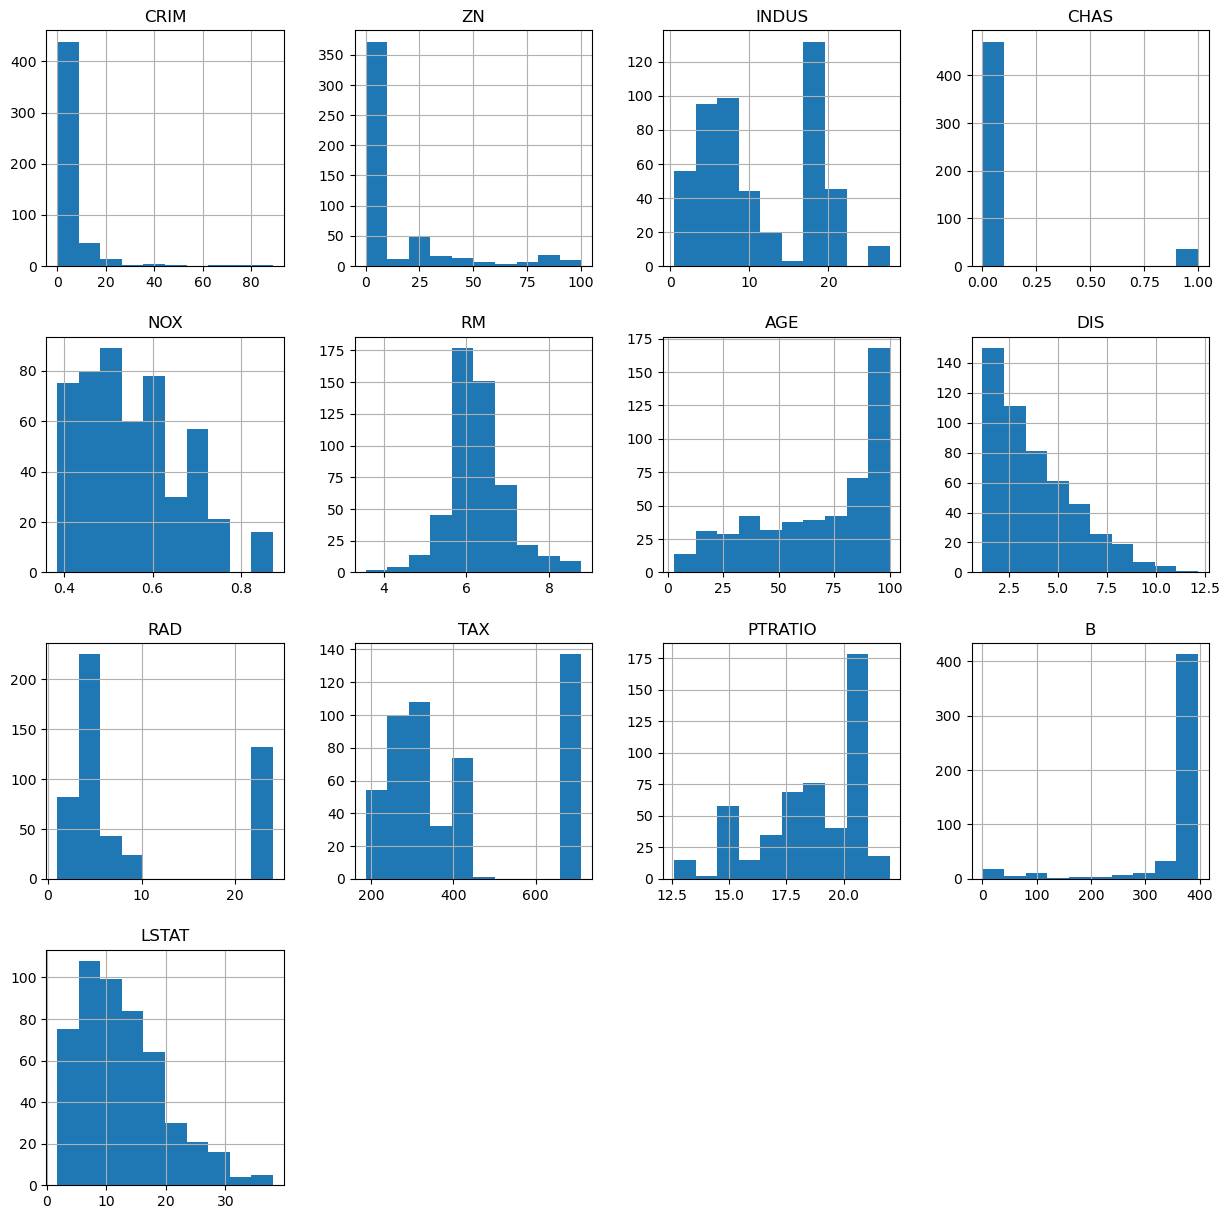

In [54]:
X.hist(figsize = [15,15]);

Informacije o međusobnim zavisnostima atributa možemo dobiti pozivom funkcije `corr` koja izračunava Pirsonov koeficijent korelacije.

In [55]:
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


Detaljnom analizom zavisnosti atributa ćemo se baviti u svesci vezanoj za selekciju atributa. Za sada možemo konstatovati da postoje atributi koji su vrlo korelisani npr. TAX i RAD ili DIS i INDUS.

## Podela skupa podataka na skupove za treniranje i testiranje

Podatke ćemo pripremiti podelom na skup za treniranje i skup za testiranje u razmeri 2:1. Vrednost `random_state` parametra ćemo postaviti nasumično na vrednost 7.

In [56]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 7)

## Standardizacija podataka

Kako se podaci sa kojima radimo odnose na različite fizičke veličine sa vrednostima koje su na različitim skalama, pre učenja modela ćemo se pozabatiti standardizacijom podataka. Standardizacija podrazumevanje centriranje vrednosti pojedinačnih atributa oko nule i njihovo skaliranje na jediničnu varijansu. Kod pod komentarima ukazuje na pojedinačne korake ovog procesa, a kako je ovo čest zadatak, koristićemo ugrađenu klasu `StandardScaler` koja automatizuje zadatke. Pozivom metode `fit` izračunavaju se potrebne statistike, a pozivom metode `transform` vrši se transformacija skupa na opisani način. Važno je napomenuti da se statistike izračunavaju na **skupu za treniranje**, a potom koriste za transformaciju i skupa za treniranje i skupa za testiranje. Sveska posvećena standardizaciji će dati više uvida i opravdati izbor ovakvih procedura. 

In [57]:
# X_means = np.mean(X_train, axis=0)
# X_std = np.std(X_train, axis=0)
# X_train = (X_train-X_means)/X_std
# X_test = (X_test-X_means)/X_std

In [58]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Učenje modela

Model ćemo kreirati pozivom funkcije `LinearRegression` i dalje trenirati pozivom funkcije `fit` nad skupom za treniranje.

In [59]:
model = linear_model.LinearRegression()

In [60]:
model.fit(X_train, y_train)

LinearRegression()

Vrednosti izračunatih koeficijenata ćemo ispisati prolaskom kroz niz `coef_`. 

In [62]:
for feature, coef in zip(column_names[:-1], model.coef_.ravel()):
    print (feature, coef)

CRIM -0.7912984250357165
ZN 0.593755121784215
INDUS 0.06452405315141407
CHAS 0.6770496739495413
NOX -1.7735716984784222
RM 3.8700416325737312
AGE -0.39432929438845116
DIS -2.7405608088072038
RAD 2.2919496264644126
TAX -1.8743793117587217
PTRATIO -2.1139020294298065
B 0.8270159811724099
LSTAT -2.8331502177297176


Vrednost slobodnog člana možemo dobiti očitavanjem `intercept_` svojstva.

In [63]:
model.intercept_

22.643067846607675

Iz razloga što su atributi na istim skalama, lakše možemo protumačiti i interpretirati vrednosti dobijenih koeficijenata. Možemo primetiti da atrubuti RM, DIS, RAD, TAX, PTRATIO, LSTAT, neki pozitivno, a neki negativno utiču u velikoj meri na vrednost ciljne promenljive. Ovim pitanjem ćemo se još detaljno baviti u svesci koja se tiče selekcije atributa.

## Evaluacija modela

Model ćemo evaluirati u terminima koeficijenta determinacije i srednjekvadratne greške na **skupu za testiranje**.

In [64]:
y_predicted = model.predict(X_test)

In [65]:
metrics.mean_squared_error(y_predicted, y_test)

25.322307423586228

In [66]:
metrics.r2_score(y_predicted, y_test)

0.5844375463291133

Možemo primetiti da je vrednost koeficijenta determinacije skromna (mada to primarno određuje prostor primene modela i neke praktične poslovne metrike) i da ima smisla probati sa unapređivanjima ovog modela.

## Čuvanje modela

Čuvanje modela podrazumeva čuvanje dobijenih koeficijenata, kao i konfiguracije samog modela. Pakete `pickle` i `joblib` možemo upotrebiti u ove svrhe. Oba paketa raspolažu metodama `dump` i `load` kojim se čuvaju tj. učitavaju parametri modela.

In [67]:
import pickle

In [68]:
model_filename = 'models/boston_houses.model'

In [69]:
with open(model_filename, 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

Uz čuvanje modela potrebno je sačuvati i scaler koji smo koristili za pripremu podataka. 

In [70]:
scaler_filename = 'models/boston_houses.scaler'

In [71]:
with open(scaler_filename, 'wb') as pickle_file:
    pickle.dump(scaler, pickle_file)

## Rekreiranje modela i ponovno korišćenje

Za učitavanje modela koristimo funkciju `load`.

In [72]:
with open(model_filename, 'rb') as pickle_file:
    model_revived = pickle.load(pickle_file)

In [73]:
with open(scaler_filename, 'rb') as pickle_file:
    scaler_revived = pickle.load(pickle_file)

Za novu instancu prilikom predviđanja vrednosti prvo pripremamo instancu, a potom i pozivamo model. Nova instanca nad kojom ćemo ovo demonstrirati je nasumični niz 13 brojeva.

In [75]:
new_instance = np.random.randn(13)

In [76]:
new_instance_scaled = scaler_revived.transform(new_instance.reshape(1, -1))

/home/ognjen/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [77]:
new_value = model_revived.predict(new_instance_scaled)

In [78]:
new_value

array([45.38531953])